In [4]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import os
import math

In [2]:
child_w1_df = pd.read_csv('1_EXP05_Full/week_1/child.csv').iloc[: , 1:]
child_w4_df = pd.read_csv('1_EXP05_Full/week_4/child.csv').iloc[: , 1:]

## Markov Chain

In [4]:
# outside = outside pre-defined boxes
# nodetection = openCV cannot find eyes
# screen, robot, parent

def transition_matrix(transitions, order=-1):
    df = pd.DataFrame(transitions)
    
    # create a new column with data shifted one space
    df['shift'] = df[0].shift(order)

    # add a count column (for group by function)
    df['count'] = 1

    # groupby and then unstack, fill the zeros
    trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

    # normalise by occurences and save values to get transition matrix
    trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).values
    labels = np.unique(transitions)
    
    return trans_mat, labels

In [5]:
transitions_w1 = np.asarray(child_w1_df[child_w1_df['object'] != 'nodetection']['object'])
transitions_w4 = np.asarray(child_w4_df[child_w4_df['object'] != 'nodetection']['object'])

trans_mat_w1, labels_w1 = transition_matrix(transitions_w1, order=-1)
trans_mat_w4, labels_w4 = transition_matrix(transitions_w4, order=-1)

In [6]:
# x-axis = next state
# y-axis = current state

print(trans_mat_w1, labels_w1)
print(trans_mat_w4, labels_w4)

[[0.33606557 0.00409836 0.04918033 0.61065574]
 [0.66666667 0.33333333 0.         0.        ]
 [0.2027027  0.         0.18918919 0.60810811]
 [0.34688995 0.00239234 0.11483254 0.53588517]] ['outside' 'parent' 'robot' 'screen']
[[0.2        0.00656934 0.06642336 0.7270073 ]
 [0.15384615 0.17948718 0.38461538 0.28205128]
 [0.15445026 0.02225131 0.19895288 0.62434555]
 [0.33586469 0.00207111 0.17466344 0.48740076]] ['outside' 'parent' 'robot' 'screen']


In [7]:
def KL(P,Q):
     epsilon = 0.00001
     P = P+epsilon
     Q = Q+epsilon

     divergence = np.sum(P*np.log(P/Q))
     return divergence

print('\nKL(week 1 || week 4): ')
for i in range(0, len(trans_mat_w1)):
    print(labels_w1[i], KL(trans_mat_w1[i], trans_mat_w4[i]))

print('\nKL(week 4 || week 1): ')
for i in range(0, len(trans_mat_w1)):
    print(labels_w4[i], KL(trans_mat_w4[i], trans_mat_w1[i]))


KL(week 1 || week 4): 
outside 0.05119579032370833
parent 1.1836753512630664
robot 0.02948639608143425
screen 0.01420883668398295

KL(week 4 || week 1): 
outside 0.04605493955574122
parent 6.614315999567413
robot 0.15606386867094638
screen 0.01588168023953932


## ANOVA on Gaze

In [3]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})

### Data Processing

In [4]:
PID = '1_EXP05_Full/'

In [5]:
# read data
df_c_w1 = pd.read_csv(PID + 'week_1/' + 'child.csv')
df_c_w2 = pd.read_csv(PID + 'week_2/' + 'child.csv')
df_c_w3 = pd.read_csv(PID + 'week_3/' + 'child.csv')
df_c_w4 = pd.read_csv(PID + 'week_4/' + 'child.csv')

In [6]:
# remove rows where the duration is 0
df_c_w1 = df_c_w1[df_c_w1['duration'] != 0]
df_c_w2 = df_c_w2[df_c_w2['duration'] != 0]
df_c_w3 = df_c_w3[df_c_w3['duration'] != 0]
df_c_w4 = df_c_w4[df_c_w4['duration'] != 0]

In [7]:
# remove outliers
df_c_w1 = df_c_w1[(np.abs(stats.zscore(df_c_w1['duration'])) < 3)].reset_index()
df_c_w2 = df_c_w2[(np.abs(stats.zscore(df_c_w2['duration'])) < 3)].reset_index()
df_c_w3 = df_c_w3[(np.abs(stats.zscore(df_c_w3['duration'])) < 3)].reset_index()
df_c_w4 = df_c_w4[(np.abs(stats.zscore(df_c_w4['duration'])) < 3)].reset_index()

In [11]:
# determine unique days in dataset
_, unique_days_w1 = get_unique_days(df_c_w1['start'])
_, unique_days_w2 = get_unique_days(df_c_w2['start'])
_, unique_days_w3 = get_unique_days(df_c_w3['start'])
_, unique_days_w4 = get_unique_days(df_c_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [12]:
# set day (of study) identifier
df_c_w1['day'] = df_c_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_c_w2['day'] = df_c_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_c_w3['day'] = df_c_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_c_w4['day'] = df_c_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [13]:
# set week identifier
df_c_w1['week'] = 1
df_c_w2['week'] = 2
df_c_w3['week'] = 3
df_c_w4['week'] = 4

In [14]:
# apply data transform
df_c_w1['log_duration'] = df_c_w1['duration'].apply(lambda x: math.log(x))
df_c_w2['log_duration'] = df_c_w2['duration'].apply(lambda x: math.log(x))
df_c_w3['log_duration'] = df_c_w3['duration'].apply(lambda x: math.log(x))
df_c_w4['log_duration'] = df_c_w4['duration'].apply(lambda x: math.log(x))

In [17]:
# remove index
df_c_w1 = df_c_w1.iloc[:, 1:]
df_c_w2 = df_c_w2.iloc[:, 1:]
df_c_w3 = df_c_w3.iloc[:, 1:]
df_c_w4 = df_c_w4.iloc[:, 1:]

In [18]:
# check table formatting
df_c_w1

,object,duration,start,day,week,log_duration
0,nodetection,14.193398,1.499458e+09,0,1,2.652777
1,outside,22.588879,1.499458e+09,0,1,3.117458
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768
3,outside,0.099960,1.499458e+09,0,1,-2.302987
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088
...,...,...,...,...,...,...
1241,outside,0.900717,1.500052e+09,3,1,-0.104564
1242,nodetection,0.999582,1.500052e+09,3,1,-0.000418
1243,screen,2.700183,1.500052e+09,3,1,0.993319
1244,nodetection,5.200912,1.500052e+09,3,1,1.648834


In [19]:
# combine all week dataframes
frames = [df_c_w1, df_c_w2, df_c_w3, df_c_w4]
df_c = pd.concat(frames)
df_c

,object,duration,start,day,week,log_duration
0,nodetection,14.193398,1.499458e+09,0,1,2.652777
1,outside,22.588879,1.499458e+09,0,1,3.117458
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768
3,outside,0.099960,1.499458e+09,0,1,-2.302987
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088
...,...,...,...,...,...,...
6028,outside,3.499960,1.502152e+09,20,4,1.252751
6029,screen,0.300027,1.502152e+09,20,4,-1.203882
6030,outside,0.800036,1.502152e+09,20,4,-0.223099
6031,screen,2.500126,1.502152e+09,20,4,0.916341


In [6]:
# all participants
PIDS = ['1_EXP05/', '2_EXP01/']
    #, '3_EXP02/', '4_EXP06/', '5_EXP07/',
    #'6_EXP04/', '7_EXP03/', '8_EXP11/', '9_EXP12/', '11_EXP13/',
    #'12_EXP08/', '14_EXP14/'

In [35]:
frames_df = []

for p in PIDS:
    print('processing', p)
    
    # read data
    df_c_w1 = pd.read_csv(p + 'week_1/' + 'child.csv')
    df_c_w2 = pd.read_csv(p + 'week_2/' + 'child.csv')
    df_c_w3 = pd.read_csv(p + 'week_3/' + 'child.csv')
    df_c_w4 = pd.read_csv(p + 'week_4/' + 'child.csv')
    
    # remove rows where the duration is 0
    df_c_w1 = df_c_w1[df_c_w1['duration'] != 0]
    df_c_w2 = df_c_w2[df_c_w2['duration'] != 0]
    df_c_w3 = df_c_w3[df_c_w3['duration'] != 0]
    df_c_w4 = df_c_w4[df_c_w4['duration'] != 0]
    
    # remove outliers
    df_c_w1 = df_c_w1[(np.abs(stats.zscore(df_c_w1['duration'])) < 3)].reset_index()
    df_c_w2 = df_c_w2[(np.abs(stats.zscore(df_c_w2['duration'])) < 3)].reset_index()
    df_c_w3 = df_c_w3[(np.abs(stats.zscore(df_c_w3['duration'])) < 3)].reset_index()
    df_c_w4 = df_c_w4[(np.abs(stats.zscore(df_c_w4['duration'])) < 3)].reset_index()

    # determine unique days in dataset
    _, unique_days_w1 = get_unique_days(df_c_w1['start'])
    _, unique_days_w2 = get_unique_days(df_c_w2['start'])
    _, unique_days_w3 = get_unique_days(df_c_w3['start'])
    _, unique_days_w4 = get_unique_days(df_c_w4['start'])

    unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
    
    # set day (of study) identifier
    df_c_w1['day'] = df_c_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
    df_c_w2['day'] = df_c_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
    df_c_w3['day'] = df_c_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
    df_c_w4['day'] = df_c_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

    # set week identifier
    df_c_w1['week'] = 1
    df_c_w2['week'] = 2
    df_c_w3['week'] = 3
    df_c_w4['week'] = 4
    
    # apply data transform
    df_c_w1['log_duration'] = df_c_w1['duration'].apply(lambda x: math.log(x))
    df_c_w2['log_duration'] = df_c_w2['duration'].apply(lambda x: math.log(x))
    df_c_w3['log_duration'] = df_c_w3['duration'].apply(lambda x: math.log(x))
    df_c_w4['log_duration'] = df_c_w4['duration'].apply(lambda x: math.log(x))
    
    # combine all week dataframes
    frames = [df_c_w1, df_c_w2, df_c_w3, df_c_w4]
    df_c_p = pd.concat(frames)
    df_c_p['PID'] = p
    
    # remove index
    df_c_p = df_c_p.iloc[:, 2:]
    
    frames_df.append(df_c_p)
    
df_c = pd.concat(frames_df, ignore_index=True)

processing 1_EXP05/
processing 2_EXP01/


In [36]:
df_c

,object,duration,start,day,week,log_duration,PID
0,nodetection,14.193398,1.499458e+09,0,1,2.652777,1_EXP05/
1,outside,22.588879,1.499458e+09,0,1,3.117458,1_EXP05/
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768,1_EXP05/
3,outside,0.099960,1.499458e+09,0,1,-2.302987,1_EXP05/
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088,1_EXP05/
...,...,...,...,...,...,...,...
11885,outside,0.099465,1.502215e+09,6,4,-2.307951,2_EXP01/
11886,screen,5.099890,1.502215e+09,6,4,1.629219,2_EXP01/
11887,nodetection,0.499496,1.502215e+09,6,4,-0.694155,2_EXP01/
11888,screen,7.999662,1.502215e+09,6,4,2.079399,2_EXP01/


### Plots

In [21]:
# which object are we looking at?
obj = 'parent'

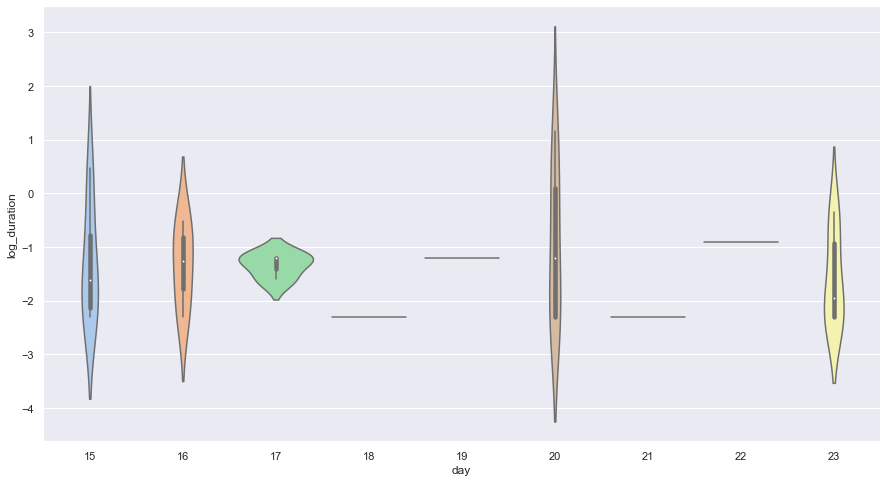

In [241]:
# example daily analysis, one week
ax = sns.violinplot(x="day", y="log_duration", data=df_c_w4[df_c_w4['object'] == obj], palette="pastel")

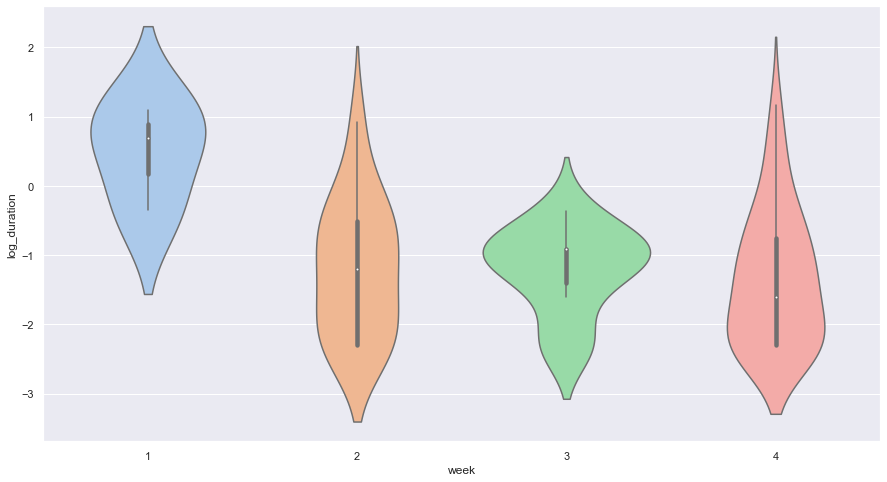

In [243]:
# example weekly analysis, entire study
ax = sns.violinplot(x="week", y="log_duration", data=df_c[df_c['object'] == obj], palette="pastel")

### One-Way ANOVA

In [37]:
df_c_summary = pd.DataFrame({
    'Week 1': df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['duration'], # df_c_w1[df_c_w1['object'] == obj]['duration'], 
    'Week 2': df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['duration'], # df_c_w2[df_c_w2['object'] == obj]['duration'], 
    'Week 3': df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['duration'], # df_c_w3[df_c_w3['object'] == obj]['duration'], 
    'Week 4': df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['duration']  # df_c_w4[df_c_w4['object'] == obj]['duration']
})

In [38]:
df_c_summary.describe()

,Week 1,Week 2,Week 3,Week 4
count,66.000000,220.000000,78.000000,89.000000
mean,0.998098,0.595055,0.512879,0.777541
std,1.319642,0.663780,0.620476,0.911990
min,0.099592,0.099516,0.099534,0.099789
25%,0.199574,0.100358,0.199897,0.199980
50%,0.349871,0.300526,0.299904,0.400100
75%,1.174327,0.799989,0.600013,0.900071
max,5.597485,3.699827,3.399907,4.199636


In [41]:
# one-way ANOVA, check if model is significant
F, p = stats.f_oneway(
    df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['log_duration'], # df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['log_duration'], # df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['log_duration'], # df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['log_duration']  # df_c_w4[df_c_w4['object'] == obj]['duration']
)

print('F-Statistic=%.3f, p=%.3f' % (F, p))

# if we see that p-value is < 0.05. 
# we can reject the null hypothesis which states that there is no difference among the different density groups

F-Statistic=2.357, p=0.071


In [45]:
from statsmodels.formula.api import ols

# one-way ANOVA, regress against each input variable to check influence over the target variable
model = ols('log_duration ~ C(week)', df_c[df_c['object'] == obj]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.357
Date:                Fri, 18 Mar 2022   Prob (F-statistic):             0.0711
Time:                        16:09:44   Log-Likelihood:                -669.98
No. Observations:                 453   AIC:                             1348.
Df Residuals:                     449   BIC:                             1364.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.7691      0.131     -5.858      0.000      -1.027      -0.511
C(week)[T.2]    -0.2762      0.150     -1.845      0.066      -0.570       0.018
C(week)[T.3]    -0.3897      0.178     -2.184      0.029      -0.740      -0.039
C(week)[T.4]    -0.0731      0.173     -0.422      0.673      -0.414       0.267
==============================================================================
Omnibus:                       74.921   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.394
Skew:                           0.319   Prob(JB):                     5.05e-06
Kurtosis:                       2.058   Cond. No.                         6.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# check if overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 3, 449) =  2.357, p =  0.0711


In [46]:
import statsmodels.api as sm

# create the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# from the output, we see that the p  >0.05. 
# Therefore, we cannot reject the null hypothesis. 
# There is no difference among the different weeks

,sum_sq,df,F,PR(>F)
C(week),8.045773,3.0,2.357447,0.071105
Residual,510.800019,449.0,NaN,NaN


### Post Hoc

In [48]:
import statsmodels.stats.multicomp

# tukey hsd test to examine where the group differences lie
mc = statsmodels.stats.multicomp.MultiComparison(df_c['log_duration'], df_c['week'])
mc_results = mc.tukeyhsd()
print(mc_results)

# where reject = True, there is a significant difference between the groups

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.2256  0.001 -0.3213   -0.13   True
     1      3  -0.5009  0.001 -0.5948  -0.407   True
     1      4  -0.1524  0.001 -0.2465 -0.0584   True
     2      3  -0.2753  0.001 -0.3558 -0.1948   True
     2      4   0.0732 0.0913 -0.0075  0.1539  False
     3      4   0.3485  0.001  0.2698  0.4271   True
----------------------------------------------------


In [49]:
# normality assumption check using shapiro wilk test
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

# if the p-value >0.05
# we can conclude that our data follows the gaussian distribution
# else, it doesn't follow the assumptions of the ANOVA model

0.9493828415870667 2.4909860632527092e-11


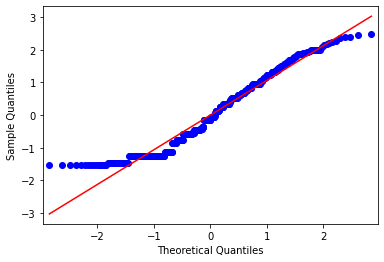

In [50]:
# using the Normal Q-Q plot to test this assumption
res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# if we see that all data points lie close to the 45-degree line
# we can conclude it follows the normal distribution

In [51]:
# homogeneity of variance assumption check

# Bartlett variance test, Method 1
wb, pb = stats.bartlett(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)
print('Bartlett variance test: w=%.3f, p=%.3f' % (wb, pb))

# Levene variance test, Method 2
wl, pl = stats.levene(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)
print('Levene variance test: w=%.3f, p=%.3f' % (wl, pl))

# if we see p > 0.05 for all weeks
# we can conclude that groups have equal variances

Bartlett variance test: w=65.879, p=0.000
Levene variance test: w=4.746, p=0.003


### Two-Way ANOVA

In [52]:
model2 = ols('log_duration ~ C(week)+ C(object)', df_c).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     100.9
Date:                Fri, 18 Mar 2022   Prob (F-statistic):          6.64e-144
Time:                        16:10:35   Log-Likelihood:                -19494.
No. Observations:               11890   AIC:                         3.900e+04
Df Residuals:                   11882   BIC:                         3.906e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2193      0.034     -6.430      0.000      -0.286      -0.152
C(week)[T.2]            -0.2210      0.037     -6.017      0.000      -0.293      -0.149
C(week)[T.3]            -0.5457      0.036    -15.179      0.000      -0.616      -0.475
C(week)[T.4]            -0.1788      0.036     -4.962      0.000      -0.249      -0.108
C(object)[T.outside]    -0.3705      0.034    -10.810      0.000      -0.438      -0.303
C(object)[T.parent]     -0.5290      0.063     -8.348      0.000      -0.653      -0.405
C(object)[T.robot]      -0.3219      0.041     -7.930      0.000      -0.402      -0.242
C(object)[T.screen]      0.1915      0.029      6.506      0.000       0.134       0.249
==============================================================================
Omnibus:                      307.007   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.983
Skew:                           0.409   Prob(JB):                     1.34e-72
Kurtosis:                       3.019   Cond. No.                         7.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
print(f"Overall model F({model2.df_model: },{model2.df_resid: }) = {model2.fvalue: }, p = {model2.f_pvalue: }")

Overall model F( 7.0, 11882.0) =  100.88686538870816, p =  6.638846855233485e-144


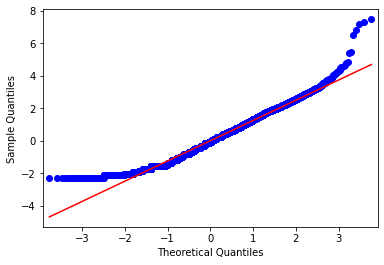

In [54]:
# create the ANOVA table
res2 = sm.stats.anova_lm(model2, typ=2)
res2

# check the Normal distribution of residuals
res = model2.resid
fig = sm.qqplot(res, line='s')
plt.show()

# from the Q-Q plot, we can see that residuals are almost normally distributed
# (although points at the extreme ends can be discounted)
# hence we conclude that it satisfies the normality assumption of the ANOVA test

In [55]:
# check the interaction of groups
formula = 'log_duration ~ C(week) *C(object)'
model = ols(formula, df_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     54.71
Date:                Fri, 18 Mar 2022   Prob (F-statistic):          2.12e-199
Time:                        16:10:49   Log-Likelihood:                -19338.
No. Observations:               11890   AIC:                         3.872e+04
Df Residuals:                   11870   BIC:                         3.886e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.3343      0.050      6.644      0.000       0.236       0.433
C(week)[T.2]                         -0.7823      0.071    -11.034      0.000      -0.921      -0.643
C(week)[T.3]                         -1.3783      0.064    -21.428      0.000      -1.504      -1.252
C(week)[T.4]                         -0.8111      0.066    -12.204      0.000      -0.941      -0.681
C(object)[T.outside]                 -0.9712      0.080    -12.138      0.000      -1.128      -0.814
C(object)[T.parent]                  -1.1034      0.160     -6.908      0.000      -1.417      -0.790
C(object)[T.robot]                   -0.9894      0.096    -10.340      0.000      -1.177      -0.802
C(object)[T.screen]                  -0.8608      0.072    -11.961      0.000      -1.002      -0.720
C(week)[T.2]:C(object)[T.outside]     0.6188      0.106      5.853      0.000       0.412       0.826
C(week)[T.3]:C(object)[T.outside]     0.9997      0.102      9.825      0.000       0.800       1.199
C(week)[T.4]:C(object)[T.outside]     0.5869      0.102      5.753      0.000       0.387       0.787
C(week)[T.2]:C(object)[T.parent]      0.5061      0.187      2.709      0.007       0.140       0.872
C(week)[T.3]:C(object)[T.parent]      0.9886      0.216      4.581      0.000       0.566       1.412
C(week)[T.4]:C(object)[T.parent]      0.7379      0.211      3.500      0.000       0.325       1.151
C(week)[T.2]:C(object)[T.robot]       0.5537      0.124      4.464      0.000       0.311       0.797
C(week)[T.3]:C(object)[T.robot]       1.2038      0.123      9.782      0.000       0.963       1.445
C(week)[T.4]:C(object)[T.robot]       0.7133      0.121      5.884      0.000       0.476       0.951
C(week)[T.2]:C(object)[T.screen]      1.1118      0.094     11.781      0.000       0.927       1.297
C(week)[T.3]:C(object)[T.screen]      1.3909      0.088     15.720      0.000       1.217       1.564
C(week)[T.4]:C(object)[T.screen]      1.2271      0.090     13.601      0.000       1.050       1.404
==============================================================================
Omnibus:                      294.759   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.469
Skew:                           0.397   Prob(JB):                     1.90e-69
Kurtosis:                       3.099   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
from statsmodels.stats.anova import anova_lm
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                       sum_sq       df         F  PR(>F)
C(week)              252.9234      3.0   49.2295     0.0
C(object)            794.5607      4.0  115.9911     0.0
C(week):C(object)    520.6585     12.0   25.3355     0.0
Residual           21581.5233  12602.0       NaN     NaN


In [239]:
mc = statsmodels.stats.multicomp.MultiComparison(df_c['log_duration'], df_c['object'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1    group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------------
nodetection outside   -0.492  0.001 -0.5859 -0.3981   True
nodetection  parent  -0.7971  0.001  -1.266 -0.3282   True
nodetection   robot  -0.3633  0.001 -0.4844 -0.2421   True
nodetection  screen   0.1136  0.001  0.0347  0.1925   True
    outside  parent  -0.3051 0.3929 -0.7756  0.1653  False
    outside   robot   0.1287 0.0449  0.0018  0.2556   True
    outside  screen   0.6056  0.001  0.5182   0.693   True
     parent   robot   0.4339 0.0943 -0.0428  0.9105  False
     parent  screen   0.9107  0.001  0.4431  1.3784   True
      robot  screen   0.4769  0.001  0.3606  0.5931   True
----------------------------------------------------------


## ANOVA on Joint Attention

In [3]:
from scipy import stats
import statsmodels.api as sm

In [4]:
PID = '1_EXP05_Full/'

In [5]:
# read from existing files
df_cr_w1 = pd.read_csv(PID + 'week_1/' + 'child-robot.csv')
df_cp_w1 = pd.read_csv(PID + 'week_1/' + 'child-parent.csv')
df_pr_w1 = pd.read_csv(PID + 'week_1/' + 'parent-robot.csv')

df_cr_w2 = pd.read_csv(PID + 'week_2/' + 'child-robot.csv')
df_cp_w2 = pd.read_csv(PID + 'week_2/' + 'child-parent.csv')
df_pr_w2 = pd.read_csv(PID + 'week_2/' + 'parent-robot.csv')

df_cr_w3 = pd.read_csv(PID + 'week_3/' + 'child-robot.csv')
df_cp_w3 = pd.read_csv(PID + 'week_3/' + 'child-parent.csv')
df_pr_w3 = pd.read_csv(PID + 'week_3/' + 'parent-robot.csv')

df_cr_w4 = pd.read_csv(PID + 'week_4/' + 'child-robot.csv')
df_cp_w4 = pd.read_csv(PID + 'week_4/' + 'child-parent.csv')
df_pr_w4 = pd.read_csv(PID + 'week_4/' + 'parent-robot.csv')

In [6]:
# remove outlier lags based on stable behavior throughout the week
df_cr_w1 = df_cr_w1[(np.abs(stats.zscore(df_cr_w1['lag'])) < 3)].reset_index()
df_cp_w1 = df_cp_w1[(np.abs(stats.zscore(df_cp_w1['lag'])) < 3)].reset_index()
df_pr_w1 = df_pr_w1[(np.abs(stats.zscore(df_pr_w1['lag'])) < 3)].reset_index()

df_cr_w2 = df_cr_w2[(np.abs(stats.zscore(df_cr_w2['lag'])) < 3)].reset_index()
df_cp_w2 = df_cp_w2[(np.abs(stats.zscore(df_cp_w2['lag'])) < 3)].reset_index()
df_pr_w2 = df_pr_w2[(np.abs(stats.zscore(df_pr_w2['lag'])) < 3)].reset_index()

df_cr_w3 = df_cr_w3[(np.abs(stats.zscore(df_cr_w3['lag'])) < 3)].reset_index()
df_cp_w3 = df_cp_w3[(np.abs(stats.zscore(df_cp_w3['lag'])) < 3)].reset_index()
df_pr_w3 = df_pr_w3[(np.abs(stats.zscore(df_pr_w3['lag'])) < 3)].reset_index()

df_cr_w4 = df_cr_w4[(np.abs(stats.zscore(df_cr_w4['lag'])) < 3)].reset_index()
df_cp_w4 = df_cp_w4[(np.abs(stats.zscore(df_cp_w4['lag'])) < 3)].reset_index()
df_pr_w4 = df_pr_w4[(np.abs(stats.zscore(df_pr_w4['lag'])) < 3)].reset_index()

In [5]:
def unix_to_datetime(ts):
    return datetime.utcfromtimestamp(ts)

def get_unique_days(df_column):
    realtime = df_column.apply(lambda x: unix_to_datetime(x))
    days = np.array(realtime.apply(lambda x: x.day))
    return days, np.unique(days)

def get_day_into_study(days, prev_days = 0):
    adj = list(range(0, len(days)))
    res = [x + prev_days for x in adj]
    return res

def search(l, n):
    for i in range(len(l)):
        if l[i] == n:
            return i
    return -1

def adjust_day(uniq, n, blind = 0):
    haystack = uniq[blind:]
    idx = search(haystack, n)
    return idx + blind

In [8]:
_, unique_days_w1 = get_unique_days(df_cr_w1['start'])
_, unique_days_w2 = get_unique_days(df_cr_w2['start'])
_, unique_days_w3 = get_unique_days(df_cr_w3['start'])
_, unique_days_w4 = get_unique_days(df_cr_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [9]:
df_cr_w1['day_study'] = df_cr_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_cr_w2['day_study'] = df_cr_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_cr_w3['day_study'] = df_cr_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_cr_w4['day_study'] = df_cr_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [93]:
# frames = [df_cr_w1, df_cr_w2, df_cr_w3, df_cr_w4]
# df_cr = pd.concat(frames)
# df_cr = df_cr.iloc[:, 1:]

In [94]:
df_cr

,object,duration,start,initiator,lag,day_study,week_study
0,contact,0.999396,1.499458e+09,robot,13.697562,0,1
1,contact,19.099964,1.499458e+09,robot,14.796889,0,1
2,contact,1.499971,1.499458e+09,robot,0.904794,0,1
3,contact,2.199933,1.499458e+09,robot,2.504795,0,1
4,contact,0.199958,1.499458e+09,robot,4.804777,0,1
...,...,...,...,...,...,...,...
6358,contact,0.000000,1.502151e+09,robot,10.845541,20,4
6359,contact,0.199831,1.502151e+09,robot,10.945595,20,4
6360,contact,0.200178,1.502151e+09,robot,11.245524,20,4
6361,contact,4.099981,1.502151e+09,robot,11.545519,20,4


In [ ]:
# across control and experimental
resumption_lag_y = df_x['te_p_resumption'] - df_x['a_p_resumption']
resumption_lag_x = df_x.drop(columns=['te_p_resumption', 'a_p_resumption'])

In [ ]:
model = sm.OLS(resumption_lag_y, resumption_lag_x)
results = model.fit()
print(results.summary())